# IEOR4571 Final Project: Matrix factorization Model and Baseline Model



Team members: Diyue Gu (dg3198), Jingyan Xu (jx2424p), Yifei Zhang (yz3925), Chelsea Cui (ac4788), Yishi Wang (yw3619)


In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 76kB/s 
     |████████████████████████████████| 204kB 52.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=700b139391c6c2405d6cf0602aea1898d30cf2d162681821cf8d04ee8b0284df
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Row
import pyspark as ps
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.mllib.evaluation import RankingMetrics
import pandas as pd
import numpy as np
rng = np.random.RandomState(42)

## Baseline Model

For basedline model, we just simply give recommendation to users by giving high rating movies. As different users will indeed have different preference to movies, we regard this baseline model as a biased model. 

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import math

In [ ]:
train_data = pd.read_csv('train.csv')
test_data_dl = pd.read_csv('test_for_dp.csv')
test_data_cb = pd.read_csv('test_for_content.csv')
test_data_mb = pd.read_csv('test_for_mf.csv')

In [ ]:
train_data.head()

,Unnamed: 0,userId,movieId,rating
0,12781059,130862,1291,5.0
1,7949428,81819,3979,1.0
2,6981779,71738,968,3.0
3,10384862,106812,51471,3.0
4,3241478,33384,1089,3.5


In [ ]:
avg_ratings = train_data[['movieId', 'rating']].groupby('movieId').mean().sort_values('rating', ascending = False)
most_popular_rate = avg_ratings.iloc[0]
most_popular_rate = float(most_popular_rate.values)

In [ ]:
test_set_list = [test_data_dl, test_data_cb, test_data_mb]

In [ ]:
for test_set in test_set_list:
    test_set['predict'] = most_popular_rate

In [ ]:
rmse_for_dl_cb_mb = []
for test_set in test_set_list:
    mse = mean_squared_error(test_set.rating, test_set.predict)
    rmse = math.sqrt(mse)
    rmse_for_dl_cb_mb.append(rmse)

In [ ]:
rmse_for_dl_cb_mb

[1.4422855066046418, 1.2858510347815848, 1.3286192124948473]

In [ ]:
test_data_dl.head()

,Unnamed: 0,userId,movieId,rating,predict
0,1,238710,5108,2.0,4.36165
1,3,193326,8861,2.5,4.36165
2,4,136171,7570,2.5,4.36165
3,5,139371,2699,3.0,4.36165
4,6,141729,413,3.5,4.36165


#### The performance of baseline on three different datasets(Corresponding to different models).

Dataset Name | RMSE
----- | -----
Data for Deep Learning  Model| 1.44
Data for Content-Based Model | 1.29
Data for Matrix factorization Model | 1.33


## Matrix factorization Model

Matrix factorization is a class of collaborative filtering algorithms used in recommender systems. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. This family of methods became widely known during the Netflix prize challenge due to its effectiveness as reported by Simon Funk in his 2006 blog post, where he shared his findings with the research community. The prediction results can be improved by assigning different regularization weights to the latent factors based on items' popularity and users' activeness.

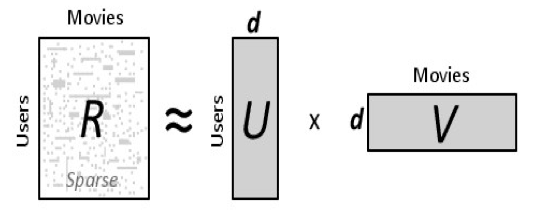

##### Alternating Least Squares(ALS)

ALS is an iterative optimization process where we for every iteration try to arrive closer and closer to a factorized representation of our original data.

Objective function for ALS (with regularization)
<br>

$$ \min_{U\in\mathbb{R}^{m \times d},V\in\mathbb{R}^{n\times d}} \sum_{(i,j)|R_{i,j}\neq 0} (R_{i,j} - \langle U_i,V_j \rangle)^2 + \lambda \cdot\Bigl(\sum_i n_{u_i}\| U_i \|^2 + \sum_j n_{v_j}\| V_j \|^2\Bigl)  $$

<br>

##### Alternating Least Square (ALS) with Spark ML

Alternating Least Square (ALS) is also a matrix factorization algorithm and it runs itself in a parallel fashion. ALS is implemented in Apache Spark ML and built for a larges-scale collaborative filtering problems. ALS is doing a pretty good job at solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.

We use the alternating least squares (ALS) algorithm to learn these latent factors. In pyspark.ml.recommendation library, we can use the following command to import ALS.
```
from pyspark.ml.recommendation import ALS
```
Parameters for ALS:
* numBlocks is the number of blocks the users and items will be partitioned 
into in order to parallelize computation (defaults to 10).
* rank is the number of latent factors in the model (defaults to 10).
* maxIter is the maximum number of iterations to run (defaults to 10).
* regParam specifies the regularization parameter in ALS (defaults to 1.0).
* implicitPrefs specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
* alpha is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).
* nonnegative specifies whether or not to use nonnegative constraints for least squares (defaults to false).

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/final'

/content/drive/.shortcut-targets-by-id/1tcYxVKkNWTWHY2i3cu2GMp52iBCMkn5R/final


In [ ]:
train_data = pd.read_csv('train.csv')
test_data_mb = pd.read_csv('test_for_mf.csv')

In [ ]:
def MF(train_set, test_set):

    spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("building recommender") \
            .getOrCreate() # create a spark session

    train_data_spark = spark.createDataFrame(train_set)
    test_data_spark = spark.createDataFrame(test_set)

    def ALS_train(train):
        als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
        model = als.fit(train_data_spark)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
        return model, evaluator

    cvModel, evaluator = ALS_train(train_data_spark)

    cvModel_pred = cvModel.transform(test_data_spark)

    test_predict = cvModel_pred.select('userId', 'movieId', 'rating', 'prediction').toPandas()

    return test_predict

In [ ]:
def recommend_single_user(recommend, single_userId, k):
    res = recommend[recommend['userId'] == single_userId][['movieId', 'prediction']].nlargest(k, 'prediction').values.tolist()
    result = [tuple(l) for l in res] 
    return result

In [ ]:
test_predict = MF(train_data, test_data_mb)

In [ ]:
test_predict.head()

,userId,movieId,rating,prediction
0,10206,1959,5.0,4.110807
1,162085,1959,3.0,2.928478
2,274030,1959,3.0,5.226338
3,120711,1959,4.0,4.871804
4,124926,1959,4.0,3.413405


In [ ]:
test_predict.to_csv("/content/drive/MyDrive/final/MFRecommendation.csv")

In [ ]:
import pandas as pd

In [ ]:
trial_mf_recommend = pd.read_csv('MFRecommendation.csv')

In [ ]:
trial_mf_recommend.shape

(42180, 5)

In [ ]:
trial_mf_recommend.userId.nunique()

4905

In [ ]:
recommend_single_user(test_predict, 162085, 3)

[(3654.0, 3.8099920749664307),
 (1276.0, 3.729273796081543),
 (1394.0, 2.785871982574463)]

In [ ]:
test_predict[test_predict['userId'] == 162085]

,userId,movieId,rating,prediction
1,162085,1959,3.0,2.531551
5598,162085,1276,4.0,3.729274
8548,162085,3654,2.0,3.809992
13784,162085,2699,2.0,2.496750
15011,162085,1394,2.0,2.785872
15519,162085,3699,3.0,2.023240
28414,162085,661,3.0,2.360433


In [ ]:
test_predict.shape

(42180, 4)

In [ ]:
test_data_mb.shape

(42180, 4)

In [ ]:
test_data_mb.head()

,Unnamed: 0,userId,movieId,rating
0,2,180025,541,4.5
1,11,214661,597,4.0
2,13,102175,2797,3.0
3,21,256048,434,3.5
4,23,190518,145839,4.0
